<a href="https://colab.research.google.com/github/johannpiedras/ML-Algorithms/blob/main/Copy_of_Doges_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Food.com and Twitter Classification

# Importing Libraries

In [ ]:
## Processing and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import nltk
import string
import re
import os
from absl import logging
from scipy.stats import multivariate_normal as mvn


## Tensorflow 
import tensorflow_hub as hub

## SKLEarn
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Initializing Modeling Definitions

### Logistic Regression

In [ ]:
 def sigmoidLR(h):
    return 1/(1 + np.exp(-h))

def cross_entropyLR(y, p_hat):
    return -(1/len(y))*np.sum(y*np.log(p_hat) + (1-y)*np.log(1 - p_hat))

def accuracyLR(y, y_hat):
    return np.mean(y == y_hat)

class LogisticRegression():
    def __init__(self, thresh = 0.5):
        self.thresh = thresh
        self.w = None
        self.b = None
        
    def fit(self, X, y, eta = 1e-3, epochs = 1e3, show_curve = False):
        epochs = int(epochs)
        N, D = X.shape
        
        self.w = np.random.randn(D)
        self.b = np.random.randn(1)
        
        J = np.zeros(epochs)
        
        for epoch in range(epochs):
            p_hat = self.__forward(X)
            J[epoch] = cross_entropyLR(y, p_hat)
            
            self.w -= eta*(1/N)*X.T@(p_hat - y)
            self.b -= eta*(1/N)*np.sum(p_hat - y)
        
        if show_curve:
            plt.figure()
            plt.plot(J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("TrainingCurve")
            plt.show()
            
    def __forward(self, X):
        return sigmoidLR(X@self.w + self.b)
    
    def predict(self, X):
        return (self.__forward(X) >= self.thresh).astype(np.int32)


#
# Running Code
#
# lr = LogisticRegression() 
# lr.fit(X, y, show_curve = True, epochs = 15000, eta = 0.2)

### K-Means

In [ ]:
def Responsibility(X, means, beta = 1e-3, *args, **kwargs):
  diff = []
  responsibilities = []

  for mean in means:
    diff = X - mean
    dist = (np.sum(diff**2, axis = 1, keepdims = True))

    numerator = np.exp(-beta*dist)
    denominator = np.sum(numerator)

    responsibility = -numerator/denominator

    responsibilities.append(responsibility)
  return np.hstack(responsibilities)

def Distance(x, means, *args, **kwargs):
  diff = []
  dists = []
  for mean in means:
    diff = x - mean
    dist = np.sqrt(np.sum(diff**2, axis = 1, keepdims = True))
    dists.append(dist)

  return np.hstack(dists)

class K_Means:
  def __init__(self, k, distance_func = Distance, beta = None):
    self.k = k
    self.distance_func = distance_func
    self.beta = beta

  def Fit(self, X, iterations = 5):
    indices = np.arange(X.shape[0])
    sample_indices = np.random.choice(indices, size = self.k, replace = False)
    self.means = X[sample_indices]

    for i in range(iterations):
      y_hat = self.Predict(X)
      self.means = []
      for j in range(self.k):
        mean = np.mean(X[y_hat == j], axis = 0)
        self.means.append(mean)
      self.means = np.vstack(self.means)

    y_hat = self.Predict(X)
    #plt.figure(figsize = (10, 7))
    #plt.scatter(X[:, 0], X[:, 1], c = y_hat, s = 1)
    #plt.scatter(self.means[:, 0], self.means[:, 1], c = 'k', s = 15)

    return y_hat

  def Predict(self, X):
    dist = self.distance_func(X, self.means, self.beta)
    y_hat = np.argmin(dist, axis = 1)

    return y_hat


# softK=K_Means(5, distance_func= Responsibilty, beta=1.4)
# softK.Fit(X, iterations=8)

## Twitter

In [ ]:
def twitter_data():

  df = pd.read_csv('/data/Ugly_Words_labeled.csv', header=None)

  df.columns = ['tweet', 'label','flip']

  print(df.label.value_counts())

  print(df[df.tweet.isnull()])

  df.iloc[342, 1] = 1.0
  df.iloc[464, 1] = 0.0
  print(df[df.label.isnull()])

  df.flip = df.flip.replace(np.nan, 0.0)
  print(df.flip.unique())

  df.dropna(inplace = True)

  print(df.shape)
  return df

In [ ]:
# Defining embedder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def cleaned_tweet(X, y):
  # Making all the tweets lower case
  for row in range(X.shape[0]):
    X.iloc[row] = X.iloc[row].lower()
  
  # Remove urls
  X_http = []
  for row in X:
    X_http.append(re.sub(r'http\S+', '', row))

  # Remove punctuation
  X0 = []
  for row in X_http:
    X0.append("".join([ char for char in row if char not in string.punctuation]))
  
  # Splitting data into training/testing
  train, test = train_test_split(X0, test_size = 0.3, train_size = 0.7, random_state = None, shuffle = False, stratify = None)

  size = int(X.shape[0]*0.7)
  y_train = y[:size]
  y_test = y[size:]

  train_embeddings = embed(train)
  test_embeddings = embed(test)

  X_train = train_embeddings.numpy()
  X_test = test_embeddings.numpy()

  return X_train, X_test, y_train.to_numpy().astype(int), y_test.to_numpy().astype(int)

## Recipes

In [ ]:
def recipe_data(X_food, y_food):
  X1 = embed(X_food['name'].to_numpy())
  X2 = embed(X_food['ingridents'].to_numpy())

  steps = []
  for i in range(len(X_food['steps'].to_numpy())):
    steps.append(str((X_food['steps'].to_numpy())[i]))

  X3 = embed(steps)

  food = np.hstack((X1, X2, X3))

  # Splitting data into training/testing
  ind = list(range(y_food.shape[0]))  # making a list of the indices for the rows
  split = int(0.7 * y_food.shape[0])  # getting 80% of the rows
  np.random.shuffle(ind)  # randomly shuffling the indices

  ind_train = ind[:split]  # taking the first 80% of the random indices of the data
  ind_test = ind[split:]  # taking the remaining 20% of the indices

  new = X2.numpy()
  X1_train = new[ind_train]
  X1_test = new[ind_test]

  #X1_train = food[ind_train]
  y1_train = y_food[ind_train]
  #X1_test = food[ind_test]
  y1_test = y_food[ind_test]

  return X1_train, X1_test, y1_train, y1_test

# Data Wrangling

## Twitter Data

In [ ]:
df = twitter_data()

Mounted at /content/drive
0.0    1168
1.0     694
Name: label, dtype: int64
     tweet  label  flip
1733   NaN    0.0   NaN
Empty DataFrame
Columns: [tweet, label, flip]
Index: []
[0. 1.]
(1863, 3)


In [ ]:
# Separating the tweet and labels 
y = df['label']
X = df['tweet']

In [ ]:
X_train, X_test, y_train, y_test = cleaned_tweet(X, y)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Recipes Data

In [ ]:
data = pd.read_csv('/data/data_recipes.csv')

data['rating'] = data.iloc[:,1].replace([0,1,2,3],0, regex = True)
data['rating'] = data.iloc[:,1].replace([4,5],1, regex = True)

In [ ]:
X_food = data[['name', 'ingridents', 'steps']]
y_food = data['rating']

In [ ]:
X1_train, X1_test, y1_train, y1_test = recipe_data(X_food, y_food)

# Modeling
Here we post main functions of the best models

## Twitter Main

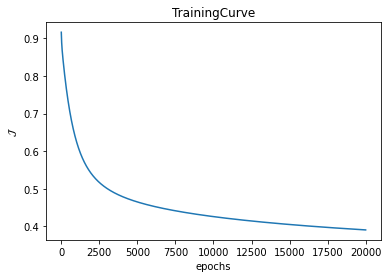

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train, eta = 1e-1, epochs = 2e4, show_curve = True)
y_logreg = log_reg.predict(X_test)

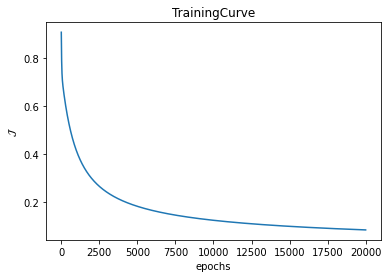

---------------------------------
Accuracy : 0.941
Precision:  0.9051987767584098
Recall:  0.9932885906040269
F1 - Score:  0.9471999999999999
---------------------------------
Positives:  296
Negative:  230
False Positives:  31
False Negatives:  2
---------------------------------


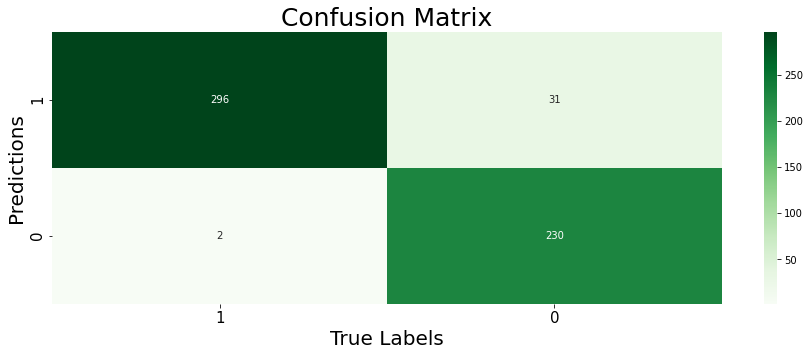

In [ ]:
softK = K_Means(2, distance_func = Responsibility, beta = 1.4)
softK.Fit(X_train, iterations = 8)

y_km_train = softK.Predict(X_train)
y_km_test = softK.Predict(X_test)

log_reg1 = LogisticRegression()
log_reg1.fit(X_train, y_km_train, eta = 1e-1, epochs = 2e4, show_curve = True)
y_logreg1 = log_reg1.predict(X_test)


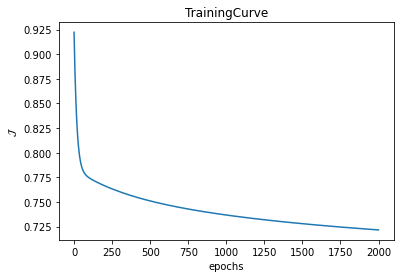

In [ ]:
log_reg2 = LogisticRegression()
log_reg2.fit(X1_train, y1_train, eta = 1e-1, epochs = 2e3, show_curve = True)
y_logreg2 = log_reg2.predict(X1_test)

In [ ]:
softK1 = K_Means(2, distance_func = Responsibility, beta = 1.4)
softK1.Fit(X1_train, iterations = 8)

y1_km_train = softK1.Predict(X1_train)
y1_km_test = softK1.Predict(X1_test)

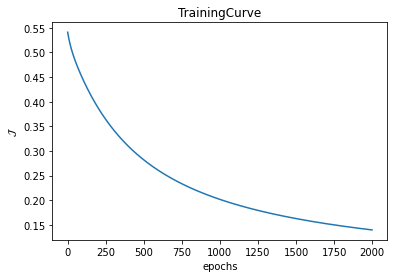

In [ ]:
# Logistic Regression with KMeans Labels
log_reg3 = LogisticRegression()
log_reg3.fit(X1_train, y1_km_train, eta = 1e-1, epochs = 2e3, show_curve = True)
y_logreg3 = log_reg3.predict(X1_test)

## Twitter

In [ ]:
def tweet_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg.predict(X_sent.numpy()))

In [ ]:
tweet_demo(["Doge coin price went up by 50% - theguardian.com"])

[1]


In [ ]:
def km_tweet_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg1.predict(X_sent.numpy()))

In [ ]:
sentence = ["Doge coin price went up by 50% - theguardian.com"]
#sentence = ["Wow, doge coin stock price just went up. Thank god for reddit"]

km_tweet_demo(sentence)

[1]


## Recipes

In [ ]:
def food_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg2.predict(X_sent.numpy()))

In [ ]:
sentence = ["tortilla beef jalapenos salt pepper cheese vegetable oil"]
sentence2 = ["expired cheese chicken liver fish oil ginger garlic paste"]

food_demo(sentence)
food_demo(sentence2)

[1]
[0]


In [ ]:
def km_food_demo(sentence):
  X_sent = embed(sentence)
  print(log_reg3.predict(X_sent.numpy()))

In [ ]:
km_food_demo(sentence)
km_food_demo(["dead body"])
# IMPORTANT NOTE: KMeans might reverse the meaning of 0 & 1

[1]
[1]
